In [533]:
import numpy as np
import pandas as pd

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error

import tensorflow as tf
from tensorflow import keras
from keras.models import Sequential
from keras.layers import LSTM, Dense, Input, Dropout, GRU, Bidirectional, SimpleRNN

import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import seaborn as sns

import pygame as pg
from visualisers.pg_visualiser import *


## Constants

In [543]:
train_size = 0.8
rng = np.random.default_rng(2048)
n_epochs = 1000
batch_size = None
len_seq = 2
spacial_dim = 3
n_hidden = 32
test_indx = 1

In [535]:
def prep_data():
    # Reading data
    dataset = pd.read_csv('csvs/lorenz.csv', header=0)
    # eliminate all white spaces from the column names
    dataset.columns = dataset.columns.str.replace(' ', '')
    # print(dataset.shape)

    # Scale the entire DataFrame
    scaler = MinMaxScaler()
    # pos_col = ['x','y','z']
    scaled_data = scaler.fit_transform(dataset[['x','y','z']])
    # print(scaled_data)

    # Convert the scaled data back to a DataFrame
    dataset[['x','y','z']] = scaled_data
    # print(dataset.shape)
        
    # format
    input_len = len(dataset[dataset['particle']==0])-2
    inputs = np.zeros((10,input_len, len_seq, spacial_dim)) # ILDC
    targets = np.zeros((10,input_len, spacial_dim))

    for i in range(10):
        particle_data = dataset[dataset['particle'] == i]
        
        particle_data = particle_data.drop(['t', 'particle'], axis=1)
        
        for j in range(len(particle_data)-2):
            inputs[i][j] = particle_data.iloc[j:j+2]
            targets[i][j] = particle_data.iloc[j+2]
            
   

    return dataset, inputs, targets

In [536]:
raw_data, inputs, targets = prep_data()
inputs[-1]


array([[[0.59843798, 0.41564213, 0.1620031 ],
        [0.57287384, 0.42445148, 0.15831815]],

       [[0.57287384, 0.42445148, 0.15831815],
        [0.55124571, 0.42854254, 0.15678982]],

       [[0.55124571, 0.42854254, 0.15678982],
        [0.53242109, 0.42850581, 0.15685416]],

       ...,

       [[0.72514746, 0.63486325, 0.48115109],
        [0.72124395, 0.63040507, 0.48005859]],

       [[0.72124395, 0.63040507, 0.48005859],
        [0.71703261, 0.62616623, 0.4783271 ]],

       [[0.71703261, 0.62616623, 0.4783271 ],
        [0.71257857, 0.62220144, 0.47600976]]])

In [537]:
# combined all the points,,, again
sequences_train_inputs, sequenced_test_inputs = inputs[:int(train_size*len(inputs))], inputs[int(train_size*len(inputs)):]
sequenced_train_targets, sequenced_test_targets = targets[:int(train_size*len(inputs))], targets[int(train_size*len(inputs)):]

train_inputs, test_inputs = sequences_train_inputs.reshape(-1, 2, 3), sequenced_test_inputs.reshape(-1, 2, 3)
train_targets, test_targets = sequenced_train_targets.reshape(-1,3), sequenced_test_targets.reshape(-1,3)
# train_inputs.shape, train_targets.shape
# print(sequences_train_inputs), test_targets.shape


## The rnn


In [538]:
def build_rnn(n_hidden=32, n_layers=1, input_shape = (2,3)):

    '''
        inputs:
        input_shape: (n_timesteps, input_dim)'''
    model = Sequential()
    for _ in range(n_layers):
        model.add(LSTM(n_hidden, input_shape=input_shape))

    model.add(Dense(3))
    model.compile(loss='mean_squared_error', optimizer='adam')
    
    return model


model = build_rnn(n_hidden)

In [539]:
# drop time and particle label
type(train_inputs) 
type(train_targets)
tf.convert_to_tensor(train_inputs)
model.fit(train_inputs, train_targets, epochs=n_epochs, batch_size=batch_size)

Epoch 1/1000
200/200 [==============================] - 4s 9ms/step - loss: 0.0401
Epoch 2/1000
200/200 [==============================] - 2s 8ms/step - loss: 0.0031
Epoch 3/1000
200/200 [==============================] - 2s 8ms/step - loss: 0.0015
Epoch 4/1000
200/200 [==============================] - 2s 8ms/step - loss: 9.2969e-04
Epoch 5/1000
200/200 [==============================] - 1s 7ms/step - loss: 5.8008e-04
Epoch 6/1000
200/200 [==============================] - 2s 8ms/step - loss: 3.6680e-04
Epoch 7/1000
200/200 [==============================] - 2s 9ms/step - loss: 2.6081e-04
Epoch 8/1000
200/200 [==============================] - 1s 7ms/step - loss: 2.1681e-04
Epoch 9/1000
200/200 [==============================] - 1s 7ms/step - loss: 1.9908e-04
Epoch 10/1000
200/200 [==============================] - 1s 7ms/step - loss: 1.8467e-04
Epoch 11/1000
200/200 [==============================] - 1s 7ms/step - loss: 1.7162e-04
Epoch 12/1000
200/200 [==============================

In [550]:
def test_rnn(model, sequenced_test_inputs, seq_indx=0):
    # Make predictions for each time step
    predicted_sequence = []
    current_step = sequenced_test_inputs[seq_indx][0].reshape(-1,2,3) # Initialize the current 2 step with the input data
    print(current_step.shape)
    for i in range(len(sequenced_test_inputs[0])):
        

        predicted_step = model.predict(current_step)
        predicted_sequence.append(predicted_step)
        # Update the current step by shifting the window
        current_step = np.concatenate([current_step[:, 1:, :], predicted_step.reshape(1,1,3)], axis=1)

    predicted_sequence = np.array(predicted_sequence)

    # processed_sequence = write_result(predicted_sequence)

    return predicted_sequence


pred_seq = test_rnn(model, sequenced_test_inputs, test_indx)

(1, 2, 3)
1/1 [==============================] - 0s 12ms/step


In [542]:
model.save('multi.h5')

## Visualisation

In [551]:
# separate x,y,z

pred_seq = pred_seq.reshape(-1,3)


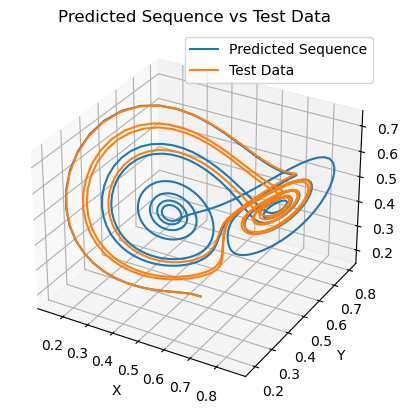

In [552]:


# Extract x, y, z coordinates from predicted sequence
pred_x = pred_seq[:, 0]
pred_y = pred_seq[:, 1]
pred_z = pred_seq[:, 2]

# Extract x, y, z coordinates from test data
test_x = sequenced_test_targets[test_indx][:, 0]
test_y = sequenced_test_targets[test_indx][:, 1]
test_z = sequenced_test_targets[test_indx][:, 2]

# Create a 3D plot
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')

# Plot the predicted sequence
ax.plot(pred_x, pred_y, pred_z, label='Predicted Sequence')

# Plot the test data
ax.plot(test_x, test_y, test_z, label='Test Data')

# Set labels and title
ax.set_xlabel('X')
ax.set_ylabel('Y')
ax.set_zlabel('Z')
ax.set_title('Predicted Sequence vs Test Data')

# Add a legend
ax.legend()

# Show the plot
plt.show()
